In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
from scipy.stats import norminvgauss, pareto


import statsmodels.api as sm

from tqdm import tqdm  # progress bar

from scipy.stats import ks_2samp, kstest, wasserstein_distance


In [3]:


# 1. Download daily close prices back to 1950
px = yf.download("^GSPC", start="1920-01-03", interval="1d")

px.columns = px.columns.droplevel(1)

px.info(verbose=True)



/var/folders/80/4sg7_lcn221gzdjhyy7hm31h0000gn/T/ipykernel_84222/1878622828.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download("^GSPC", start="1920-01-03", interval="1d")
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24499 entries, 1927-12-30 to 2025-07-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   24499 non-null  float64
 1   High    24499 non-null  float64
 2   Low     24499 non-null  float64
 3   Open    24499 non-null  float64
 4   Volume  24499 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.1 MB


In [4]:
index_hist = px.copy()

index_hist['DayChange'] = index_hist['Close'].pct_change()

index_hist['DayChangeLog'] = np.log(index_hist['DayChange'] + 1)

index_hist['NextReturn'] = index_hist['DayChange'].shift(-1)

index_hist['NextReturnLog'] = index_hist['DayChangeLog'].shift(-1)  


index_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

index_hist.dropna(inplace=True)

index_hist.head(10)


Price,Close,DayChange,DayChangeLog,NextReturn,NextReturnLog
Date,,,,,
1928-01-03,17.760000,0.005663,0.005647,-0.002252,-0.002255
1928-01-04,17.719999,-0.002252,-0.002255,-0.009594,-0.009640
1928-01-05,17.549999,-0.009594,-0.009640,0.006268,0.006248
1928-01-06,17.660000,0.006268,0.006248,-0.009060,-0.009101
1928-01-09,17.500000,-0.009060,-0.009101,-0.007429,-0.007456
1928-01-10,17.370001,-0.007429,-0.007456,-0.001151,-0.001152
1928-01-11,17.350000,-0.001151,-0.001152,0.006916,0.006893
1928-01-12,17.469999,0.006916,0.006893,0.006297,0.006277
1928-01-13,17.580000,0.006297,0.006277,-0.016496,-0.016634


In [5]:
bottom_returns = index_hist['DayChange'].sort_values().head(10)

top_returns = index_hist['DayChange'].sort_values(ascending=False).head(10)

print("Bottom 10 returns:\n", bottom_returns)
print("\nTop 10 returns:\n", top_returns)


Bottom 10 returns:
 Date
1987-10-19   -0.204669
1929-10-28   -0.129403
2020-03-16   -0.119841
1929-10-29   -0.101583
1935-04-16   -0.099671
1929-11-06   -0.099213
1946-09-03   -0.099099
2020-03-12   -0.095113
1937-10-18   -0.091216
1931-10-05   -0.090722
Name: DayChange, dtype: float64

Top 10 returns:
 Date
1933-03-15    0.166096
1929-10-30    0.125306
1931-10-06    0.123583
1939-09-05    0.118584
1932-09-21    0.118110
2008-10-13    0.115800
2008-10-28    0.107890
1931-06-22    0.105144
1935-04-17    0.096107
1933-04-20    0.095238
Name: DayChange, dtype: float64


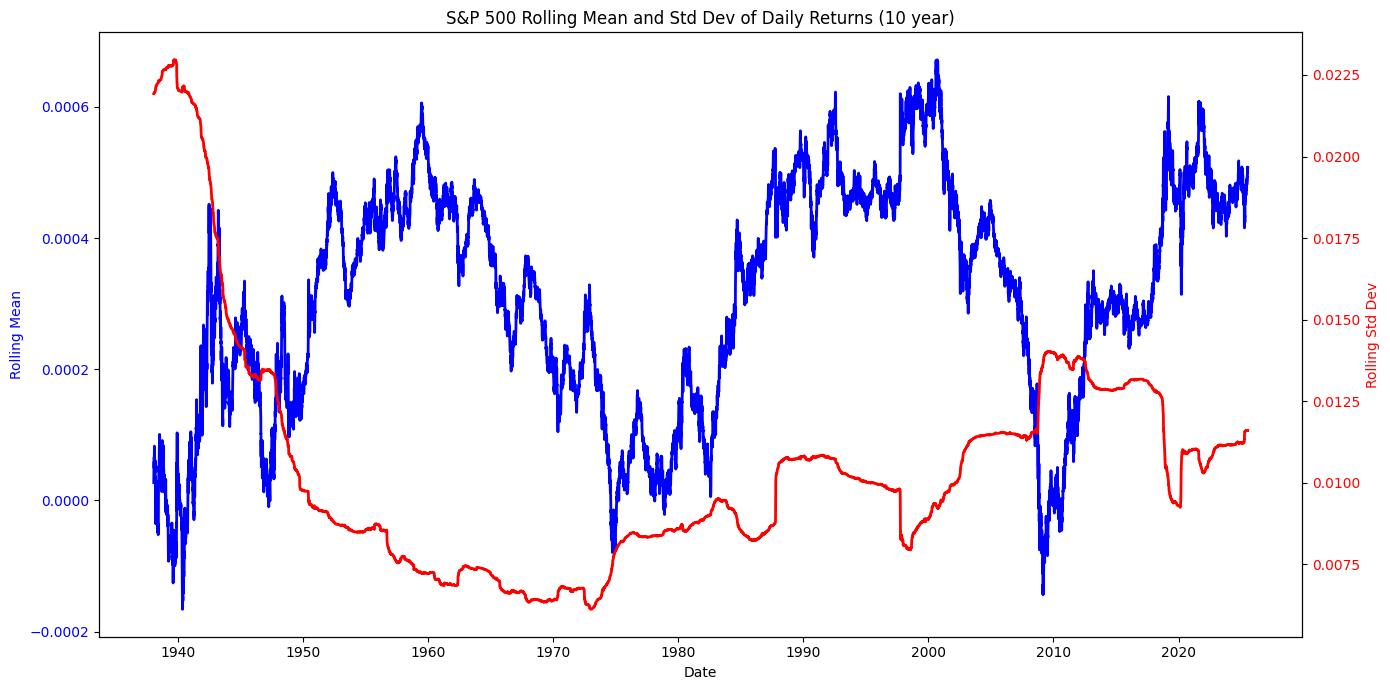

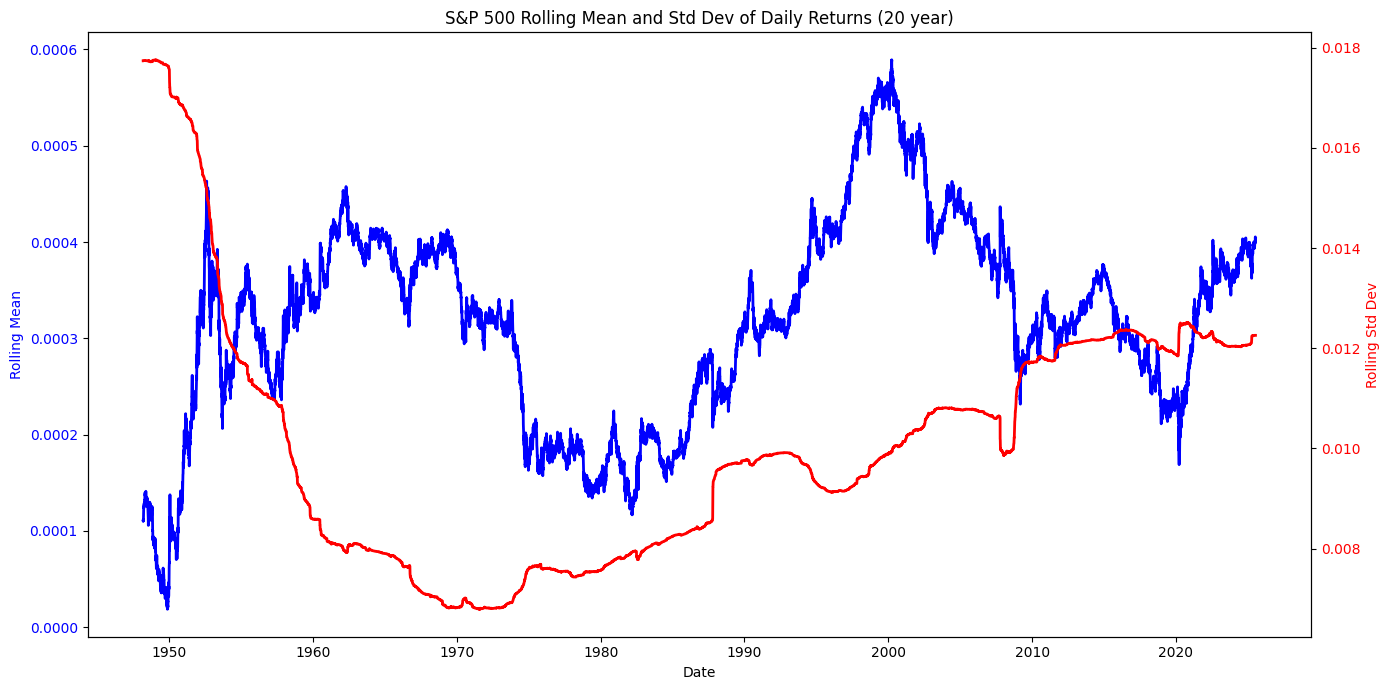

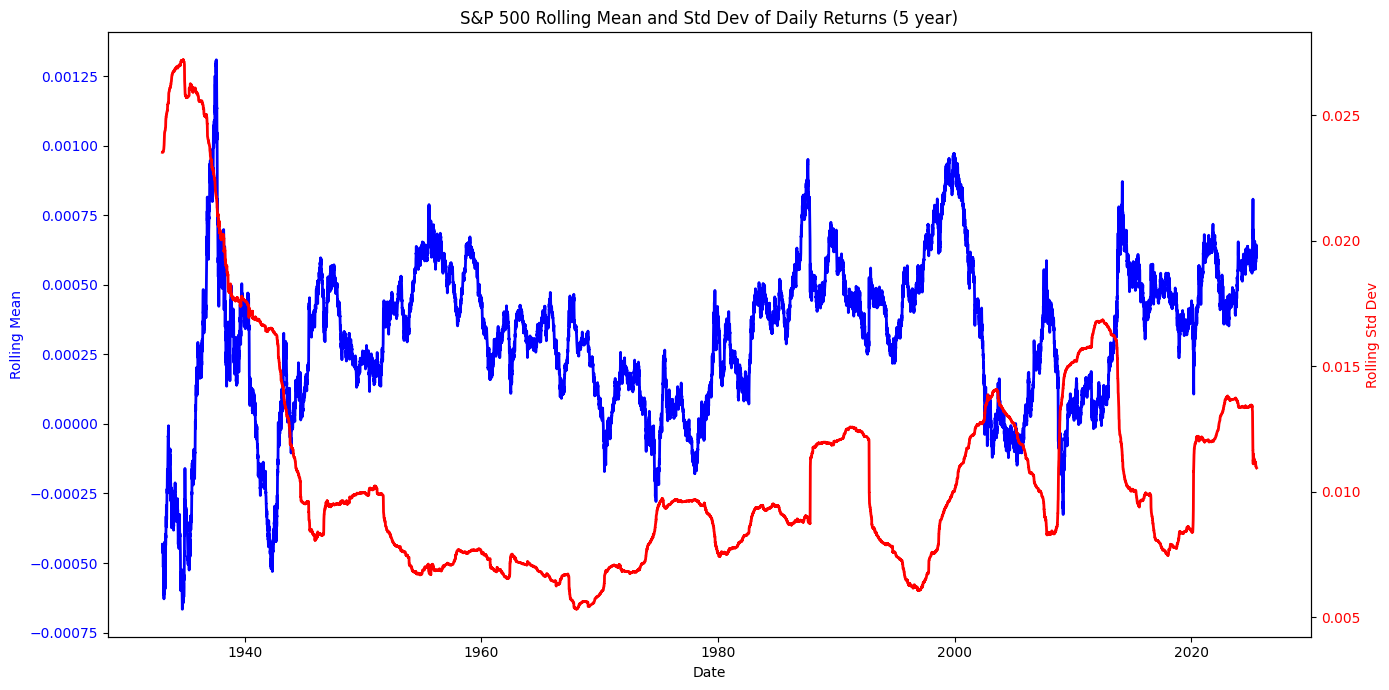

In [6]:
index_hist['RollingMean5'] = index_hist['DayChange'].rolling(window=252*5).mean()
index_hist['RollingStd5'] = index_hist['DayChange'].rolling(window=252*5).std()


# calculate a 2500-day rolling mean and standard deviation for DayChange
index_hist['RollingMean10'] = index_hist['DayChange'].rolling(window=252*10).mean()
index_hist['RollingStd10'] = index_hist['DayChange'].rolling(window=252*10).std()


index_hist['RollingMean20'] = index_hist['DayChange'].rolling(window=252*20).mean()
index_hist['RollingStd20'] = index_hist['DayChange'].rolling(window=252*20).std()


# graph the both the 5 and 10 year rolling mean and standard deviation on the same plot but with different y-axes for means and stds


# Create a figure with two y-axes
# 10 year rolling mean and std dev
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(index_hist.index, index_hist['RollingMean10'], color='blue', label='Rolling Mean (10 year)', linewidth=2)
ax1.set_ylabel('Rolling Mean', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(index_hist.index, index_hist['RollingStd10'], color='red', label='Rolling Std Dev (10 year)    ', linewidth=2)
ax2.set_ylabel('Rolling Std Dev', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_title('S&P 500 Rolling Mean and Std Dev of Daily Returns (10 year)')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.show()

# graph the 20 year rolling mean and std dev
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(index_hist.index, index_hist['RollingMean20'], color='blue', label='Rolling Mean (20 year)', linewidth=2)
ax1.set_ylabel('Rolling Mean', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(index_hist.index, index_hist['RollingStd20'], color='red', label='Rolling Std Dev (20 year)    ', linewidth=2)
ax2.set_ylabel('Rolling Std Dev', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_title('S&P 500 Rolling Mean and Std Dev of Daily Returns (20 year)')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.show()

# 5 year rolling mean and std dev
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(index_hist.index, index_hist['RollingMean5'], color='blue', label='Rolling Mean (5 year)', linewidth=2)
ax1.set_ylabel('Rolling Mean', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(index_hist.index, index_hist['RollingStd5'], color='red', label='Rolling Std Dev (5 year)    ', linewidth=2)
ax2.set_ylabel('Rolling Std Dev', color='red')
ax2.tick_params(axis='y', labelcolor='red')     
ax1.set_title('S&P 500 Rolling Mean and Std Dev of Daily Returns (5 year)')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.show()


ν=2.51, μ=0.000523, s=0.006458


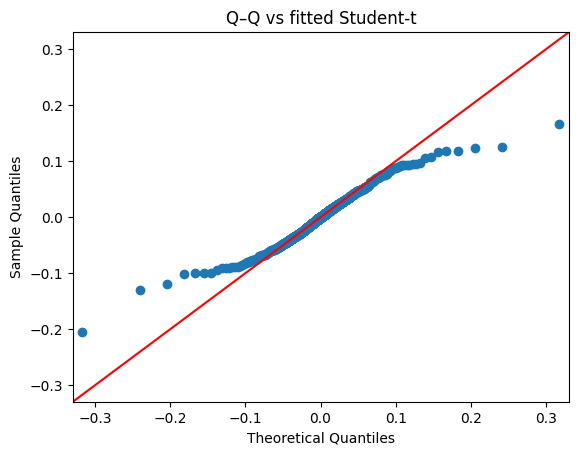

Kolmogorov–Smirnov p‑value: 0.022911879970028613


In [7]:


# r: 1‑D numpy array of (log)‑returns
r = index_hist['DayChange'].to_numpy()

# Fit (Maximum Likelihood)
df, loc, scale = stats.t.fit(r)

print(f"ν={df:.2f}, μ={loc:.6f}, s={scale:.6f}")

# Store these three numbers somewhere → your theoretical distribution


sm.qqplot(r, line='45', dist=stats.t, distargs=(df,), loc=loc, scale=scale)
plt.title("Q–Q vs fitted Student‑t")
plt.show()

ks_p = stats.kstest(r, 't', args=(df, loc, scale))[1]
print("Kolmogorov–Smirnov p‑value:", ks_p)

In [8]:

# import statsmodels.api as sm
# from scipy.stats import norminvgauss, kstest

# # 1. Extract returns vector
# r = index_hist['DayChange'].to_numpy()

# # 2. Fit NIG: returns (α, β, loc, scale)
# alpha, beta, loc, scale = norminvgauss.fit(r)
# print(f"α = {alpha:.4f}, β = {beta:.4f}, loc = {loc:.6f}, scale = {scale:.6f}")

# # 3. Q–Q Plot vs fitted NIG
# sm.qqplot(r, line='45', dist=norminvgauss,
#           distargs=(alpha, beta), loc=loc, scale=scale)
# plt.title("Q–Q Plot vs Fitted NIG Distribution")
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Sample Quantiles")
# plt.show()

# # 4. Kolmogorov–Smirnov test
# ks_stat, ks_p = kstest(r, 'norminvgauss', args=(alpha, beta, loc, scale))
# print(f"KS statistic = {ks_stat:.4f}, p-value = {ks_p:.4f}")

Left tail size: 123, cutoff: -0.0442
Right tail size: 123, cutoff: 0.0437
NIG fit → α=0.3432, β=-0.0206, loc=0.000720, scale=0.006792
GPD right tail → shape=0.1330, scale=0.017602
GPD left  tail → shape=0.0867, scale=0.017157


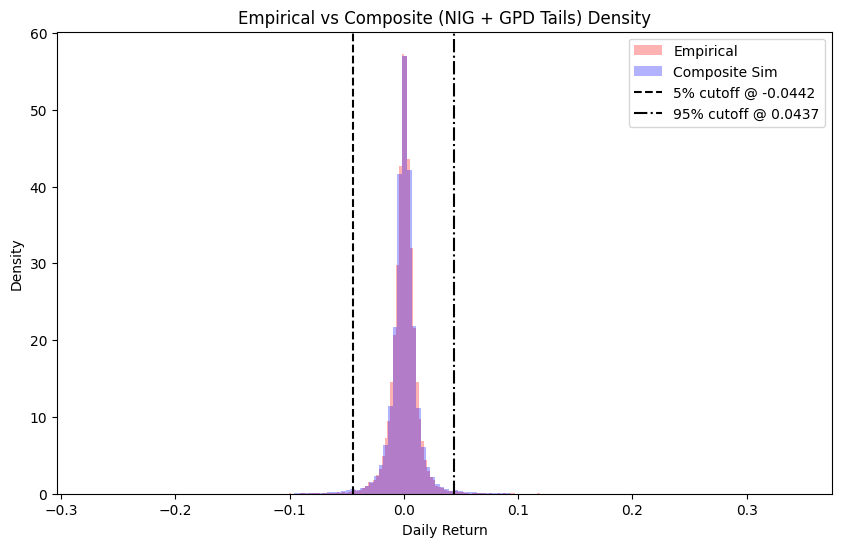

<Figure size 600x600 with 0 Axes>

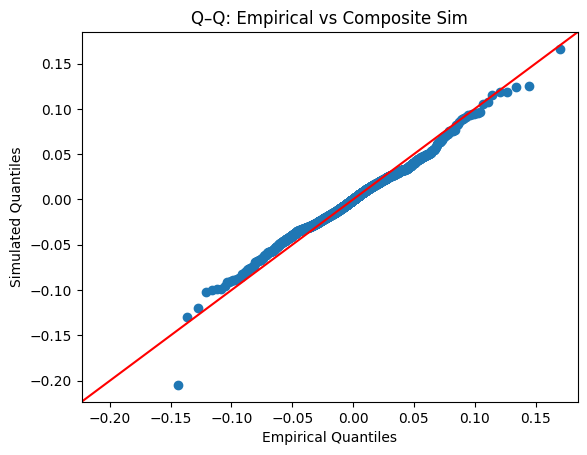

Two‐sample KS D = 0.0098, p‐value = 0.0230
Wasserstein distance: 0.0006111871330383388
KS on matched samples: 0.010205331265052853 0.15484007644153885
NIG fit → α=0.3432, β=-0.0206, loc=0.000720, scale=0.006792
GPD right tail → shape=0.1330, scale=0.017602
GPD left  tail → shape=0.0867, scale=0.017157
Lower-tail KS: D = 0.0717, p-value = 0.5457
Upper-tail KS: D = 0.0969, p-value = 0.2000
Right tail one-sample KS: 0.0994099237974212 0.16434350898125727
Left tail one-sample KS: 0.04435884455311188 0.9600080700056601


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norminvgauss, genpareto


# ———————————————————————————————————
# 1. Pull your returns
r = index_hist['DayChange'].to_numpy().copy()

# 2. Find 5% / 95% cut-offs
lower_pct, upper_pct = 0.005, 0.995
l = np.quantile(r, lower_pct)
u = np.quantile(r, upper_pct)

# 3. Split out tails and body
r_left  = r[r <  l]
r_body  = r
r_right = r[r >  u]

# print the size of each segment & cutoffs
print(f"Left tail size: {len(r_left)}, cutoff: {l:.4f}")
print(f"Right tail size: {len(r_right)}, cutoff: {u:.4f}")


# ———————————————————————————————————
# 4. Fit NIG on the entire data set 
alpha, beta, loc_nig, scale_nig = norminvgauss.fit(r_body)
print(f"NIG fit → α={alpha:.4f}, β={beta:.4f}, loc={loc_nig:.6f}, scale={scale_nig:.6f}")

# 5. Fit Generalized Pareto on each tail excess
#    (genpareto is the SciPy “POT” distribution)
c_r, loc_r, scale_r = genpareto.fit(r_right - u, floc=0)
c_l, loc_l, scale_l = genpareto.fit(l - r_left,  floc=0)
print(f"GPD right tail → shape={c_r:.4f}, scale={scale_r:.6f}")
print(f"GPD left  tail → shape={c_l:.4f}, scale={scale_l:.6f}")

# ———————————————————————————————————
# 6. Simulate composite
Nsim = 400000
u_rand = np.random.rand(Nsim)

sim = np.empty(Nsim)
mask_left  = u_rand < lower_pct
mask_body  = (u_rand >= lower_pct) & (u_rand <= upper_pct)
mask_right = u_rand > upper_pct

# body draws
sim[mask_body]  = norminvgauss.rvs(alpha, beta,
                                   loc=loc_nig, scale=scale_nig,
                                   size=mask_body.sum())
# left tail draws (mirror the GPD on the left)
sim[mask_left]  = l - genpareto.rvs(c_l, loc=0, scale=scale_l,
                                   size=mask_left.sum())
# right tail draws
sim[mask_right] = u + genpareto.rvs(c_r, loc=0, scale=scale_r,
                                   size=mask_right.sum())

# ———————————————————————————————————
# 7. Plot empirical vs composite
plt.figure(figsize=(10,6))
plt.hist(r,   bins=150, density=True, alpha=0.3,color='red', label='Empirical')
plt.hist(sim, bins=150, density=True, alpha=0.3, color='blue', label='Composite Sim')
plt.axvline(l, color='k', linestyle='--', label=f'5% cutoff @ {l:.4f}')
plt.axvline(u, color='k', linestyle='-.', label=f'95% cutoff @ {u:.4f}')
plt.legend()
plt.title("Empirical vs Composite (NIG + GPD Tails) Density")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.show()

# 8. Two‐sample Q–Q
plt.figure(figsize=(6,6))
sm.qqplot_2samples(r, sim, line='45')
plt.title("Q–Q: Empirical vs Composite Sim")
plt.xlabel("Empirical Quantiles")
plt.ylabel("Simulated Quantiles")
plt.show()

D, p = ks_2samp(r, sim)

print(f"Two‐sample KS D = {D:.4f}, p‐value = {p:.4f}")

print("Wasserstein distance:", wasserstein_distance(r, sim))


# 1. Define tail cut-offs (e.g. bottom and top 1%)
l = np.quantile(r, lower_pct)
u = np.quantile(r, upper_pct)

# 2. Extract lower and upper tail samples
r_lower = r[r < l]
sim_lower = sim[sim < l]

r_upper = r[r > u]
sim_upper = sim[sim > u]

sim_sub = np.random.choice(sim, size=len(r), replace=False)
D_sub, p_sub = ks_2samp(r, sim_sub)
print("KS on matched samples:", D_sub, p_sub)



# 3. Perform two-sample KS tests on each tail
D_lower, p_lower = ks_2samp(r_lower, sim_lower)
D_upper, p_upper = ks_2samp(r_upper, sim_upper)


print(f"NIG fit → α={alpha:.4f}, β={beta:.4f}, loc={loc_nig:.6f}, scale={scale_nig:.6f}")
print(f"GPD right tail → shape={c_r:.4f}, scale={scale_r:.6f}")
print(f"GPD left  tail → shape={c_l:.4f}, scale={scale_l:.6f}")

print(f"Lower-tail KS: D = {D_lower:.4f}, p-value = {p_lower:.4f}")
print(f"Upper-tail KS: D = {D_upper:.4f}, p-value = {p_upper:.4f}")

# right-tail excesses
ex_hi = r[r > u] - u
D_hi, p_hi = kstest(ex_hi, 'genpareto', args=(c_r, 0, scale_r))
print("Right tail one-sample KS:", D_hi, p_hi)

# left-tail excesses
ex_lo = l - r[r < l]
D_lo, p_lo = kstest(ex_lo, 'genpareto', args=(c_l, 0, scale_l))
print("Left tail one-sample KS:", D_lo, p_lo)


In [12]:
r.shape, r_body.shape, r_left.shape, r_right.shape, sim.shape

((24497,), (24497,), (123,), (123,), (400000,))

Full-sample NIG parameters:
  α (tail heaviness) = 0.3432
  β (skewness)      = -0.0206
  μ (location)      = 0.0007
  δ (scale)         = 0.0068


Rolling NIG (10 yr):   0%|          | 0/1099 [00:00<?, ?it/s]

Rolling NIG (20 yr):   0%|          | 0/973 [00:00<?, ?it/s]

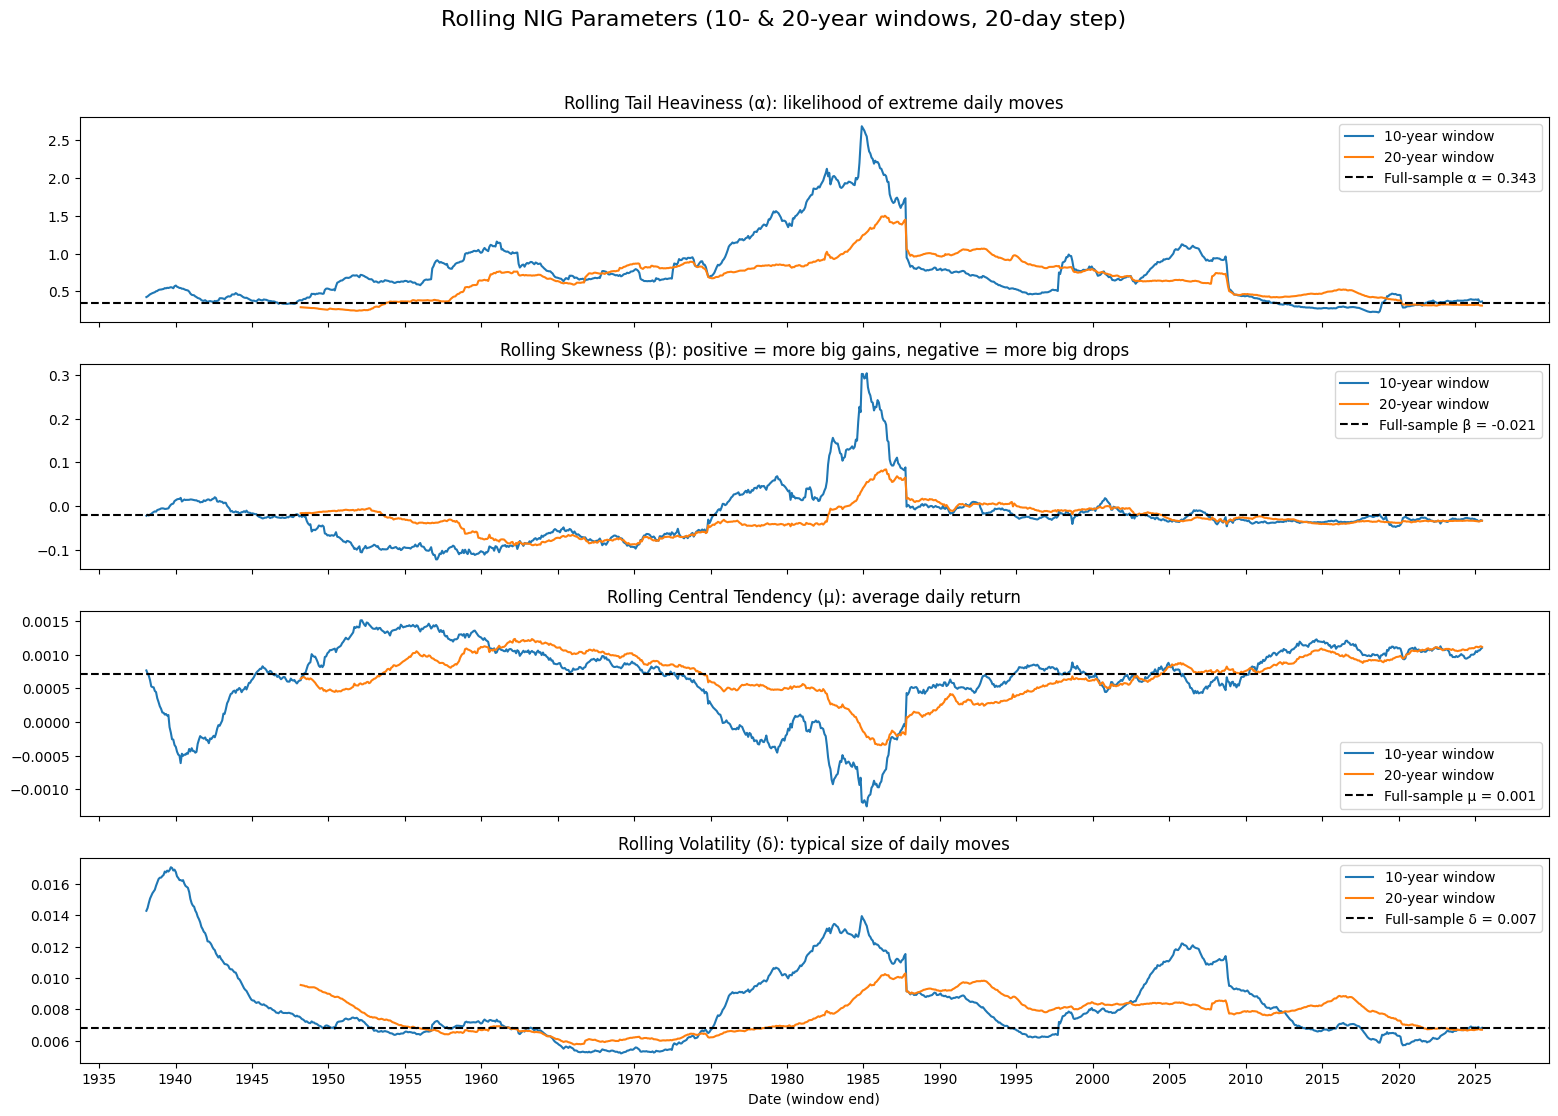

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norminvgauss
from tqdm.auto import tqdm

# — your data —
# assume index_hist is your DataFrame and has a DateTimeIndex (or similar)
r = index_hist['DayChange'].to_numpy().copy()
n_obs = len(r)

# ------------------------------------------------------------------
# 1) Fit NIG to the entire data set
# ------------------------------------------------------------------
full_alpha, full_beta, full_loc, full_scale = norminvgauss.fit(r)
print(f"Full-sample NIG parameters:\n"
      f"  α (tail heaviness) = {full_alpha:.4f}\n"
      f"  β (skewness)      = {full_beta:.4f}\n"
      f"  μ (location)      = {full_loc:.4f}\n"
      f"  δ (scale)         = {full_scale:.4f}")

# ------------------------------------------------------------------
# 2) Rolling-window estimation for both 10- and 20-year windows
# ------------------------------------------------------------------
step = 20  # ~1 month step
window_years = [10, 20]
rolling = {}

for yrs in window_years:
    win = 252 * yrs
    starts = np.arange(0, n_obs - win + 1, step)
    ends   = starts + win - 1

    alphas = np.empty(len(starts))
    betas  = np.empty(len(starts))
    locs   = np.empty(len(starts))
    scales = np.empty(len(starts))

    for j, i in enumerate(tqdm(starts, desc=f"Rolling NIG ({yrs} yr)")):
        chunk = r[i : i + win]
        a, b, mu, delta = norminvgauss.fit(chunk)
        alphas[j] = a
        betas[j]  = b
        locs[j]   = mu
        scales[j] = delta

    rolling[yrs] = pd.DataFrame(
        {'alpha': alphas, 'beta': betas, 'loc': locs, 'scale': scales},
        index=index_hist.index[ends]
    )

# ------------------------------------------------------------------
# 3) Plot both series + full-sample lines, with x-tick labels on all subplots
# ------------------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
fig.set_size_inches(fig.get_size_inches() * 1.3)
fig.suptitle(
    f"Rolling NIG Parameters (10- & 20-year windows, {step}-day step)",
    fontsize=16
)

params      = ['alpha', 'beta', 'loc',    'scale']
titles      = [
    'Rolling Tail Heaviness (α): likelihood of extreme daily moves',
    'Rolling Skewness (β): positive = more big gains, negative = more big drops',
    'Rolling Central Tendency (μ): average daily return',
    'Rolling Volatility (δ): typical size of daily moves'
]
full_vals   = [full_alpha, full_beta, full_loc, full_scale]
full_labels = [
    f"Full-sample α = {full_alpha:.3f}",
    f"Full-sample β = {full_beta:.3f}",
    f"Full-sample μ = {full_loc:.3f}",
    f"Full-sample δ = {full_scale:.3f}"
]

for ax, p, title, fv, fl in zip(axes, params, titles, full_vals, full_labels):
    # plot each window length
    for yrs, df in rolling.items():
        df[p].plot(ax=ax, label=f"{yrs}-year window")
    ax.axhline(fv, linestyle='--', color='black', label=fl)
    ax.set_title(title)
    ax.legend()

    # 5-year major ticks, no minors
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.minorticks_off()

    # ensure x-tick labels show up on this subplot
    ax.tick_params(axis='x', which='major', labelbottom=True)
    # add an x-axis label under each subplot
    ax.set_xlabel('Date (window end)')

    # rotate & center
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(0)
        lbl.set_ha('center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norminvgauss, ks_2samp
from tqdm.auto import tqdm

# — your data —
# index_hist  must be a DataFrame with a DateTimeIndex and a 'DayChange' column
r = index_hist['DayChange'].to_numpy().copy()
n_obs = len(r)

# ------------------------------------------------------------------
# 1)  Full‑sample NIG fit
# ------------------------------------------------------------------
full_alpha, full_beta, full_loc, full_scale = norminvgauss.fit(r)
print(f"Full‑sample NIG parameters:"
      f"\n  α (tail heaviness) = {full_alpha:.4f}"
      f"\n  β (skewness)      = {full_beta:.4f}"
      f"\n  μ (location)      = {full_loc:.4f}"
      f"\n  δ (scale)         = {full_scale:.4f}")

# ------------------------------------------------------------------
# 2)  Rolling fits for 10‑ and 20‑year windows  (+ KS metrics)
# ------------------------------------------------------------------

tail_size = 0.1  # 10% left / 90% right
step_days   = 1       # ≈ one month
window_years = [10, 20] # the two horizons we want
rolling = {}            # dict: years → DataFrame with parameters & KS stats

for yrs in window_years:
    win_len = 252 * yrs                # trading‑day length of the window
    starts  = np.arange(0, n_obs - win_len + 1, step_days)
    ends    = starts + win_len - 1

    n_win   = len(starts)
    out = {k: np.empty(n_win) for k in
           ['alpha','beta','loc','scale',
            'ks_d','ks_p','tail_d_left','tail_d_right','tail_p_left','tail_p_right', 'tail_d', 'tail_p']}

    for j, i in enumerate(tqdm(starts, desc=f"Rolling NIG ({yrs} y)")):
        sample = r[i:i+win_len]

        # 2‑a  Fit NIG to this window
        a, b, mu, delta = norminvgauss.fit(sample)
        out['alpha'][j], out['beta'][j] = a, b
        out['loc'][j],   out['scale'][j]= mu, delta

        # 2‑b  Draw synthetic sample from the fitted NIG (same size)
        synth = norminvgauss.rvs(a, b, loc=mu, scale=delta, size=win_len)

        # ------------ KS: full sample ------------
        d_main, p_main = ks_2samp(sample, synth, alternative='two-sided')
        out['ks_d'][j], out['ks_p'][j] = d_main, p_main

        # ------------ KS: tails  (10% left / 90% right) ------------
        q10, q90 = np.quantile(sample, [tail_size, 1-tail_size])  # e.g. 10% / 90% quantiles

        left_emp  = sample[sample <= q10]
        right_emp = sample[sample >= q90]

        # matching synthetic tails (resample until we have at least same size)
        while True:
            synth_tail = norminvgauss.rvs(a, b, loc=mu, scale=delta,
                                           size=2*win_len)  # oversample
            left_syn  = synth_tail[synth_tail <= q10][:len(left_emp)]
            right_syn = synth_tail[synth_tail >= q90][:len(right_emp)]
            if len(left_syn) == len(left_emp) and len(right_syn) == len(right_emp):
                break

        d_left,  p_left  = ks_2samp(left_emp,  left_syn)
        d_right, p_right = ks_2samp(right_emp, right_syn)

        out['tail_d_left'][j] = d_left
        out['tail_d_right'][j] = d_right
        out['tail_p_left'][j] = p_left
        out['tail_p_right'][j] = p_right

        out['tail_d'][j] = (d_left + d_right) / 2.0
        out['tail_p'][j] = (p_left + p_right) / 2.0

    df = pd.DataFrame(out, index=index_hist.index[ends])

    # #  look at around a month of data with 20 days being roughly one trading month
    df['tail_d_mean'] = df['tail_d'].rolling(window=20//step_days).mean()  
    df['tail_p_mean'] = df['tail_p'].rolling(window=20//step_days).mean()  
    df['ks_d_mean']   = df['ks_d'].rolling(window=20//step_days).mean()
    df['ks_p_mean']   = df['ks_p'].rolling(window=20//step_days).mean()

    rolling[yrs] = df



Full‑sample NIG parameters:
  α (tail heaviness) = 0.3432
  β (skewness)      = -0.0206
  μ (location)      = 0.0007
  δ (scale)         = 0.0068


Rolling NIG (10 y):   0%|          | 0/21978 [00:00<?, ?it/s]

Rolling NIG (20 y):   0%|          | 0/19458 [00:00<?, ?it/s]

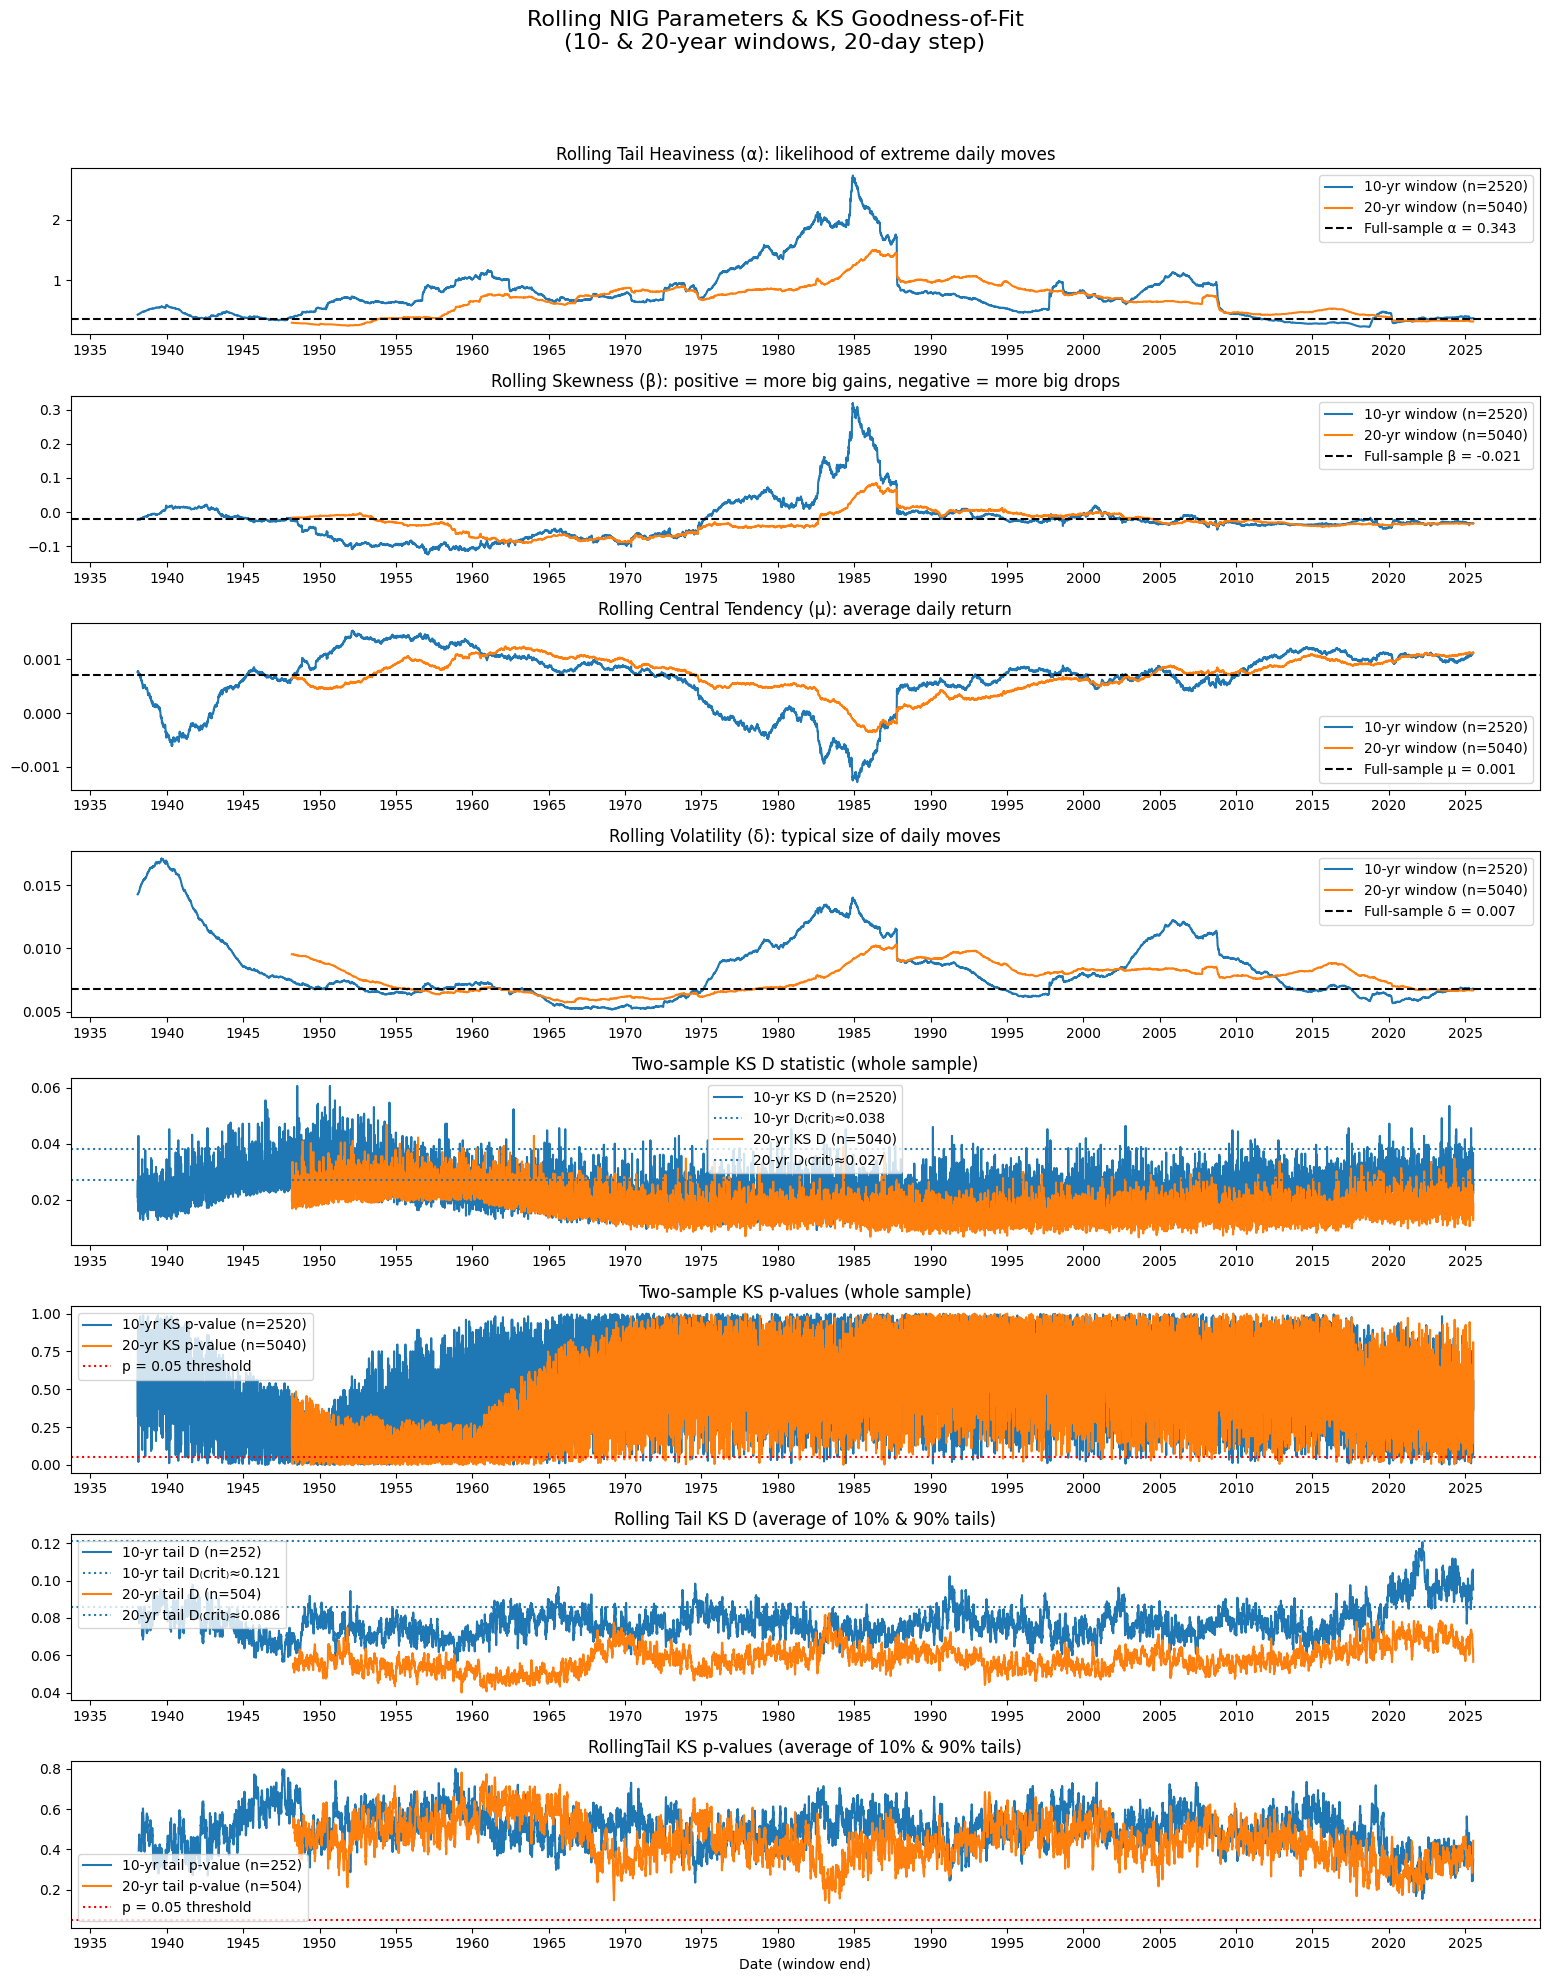

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# — assume you already have:
#    full_alpha, full_beta, full_loc, full_scale
#    rolling = {10: df10yr, 20: df20yr}

tail_size = 0.1  # 10% left / 90% right
window_years = sorted(rolling.keys())
# compute true window lengths and tail sample sizes
win_lens      = {yrs: 252 * yrs for yrs in window_years}
tail_counts   = {yrs: int(tail_size * win_lens[yrs]) for yrs in window_years}
# KS critical values for full & tail samples at α=0.05
ks_crit_full  = {yrs: 1.36 * np.sqrt(2 / win_lens[yrs]) for yrs in window_years}
ks_crit_tail  = {yrs: 1.36 * np.sqrt(2 / tail_counts[yrs]) for yrs in window_years}

# ------------------------------------------------------------------
# 3) Plot 8 panels: 4 NIG params + 4 KS metrics (with annotations)
# ------------------------------------------------------------------
fig, axes = plt.subplots(8, 1, figsize=(8.5, 11), sharex=True)
fig.set_size_inches(fig.get_size_inches() * 1.3)
fig.suptitle(
    "Rolling NIG Parameters & KS Goodness-of-Fit\n"
    f"{window_years} year windows, {step_days}-day step)",
    fontsize=16
)

# 1–4: NIG parameter panels
params    = ['alpha','beta','loc','scale']
titles    = [
    'Rolling Tail Heaviness (α): likelihood of extreme daily moves',
    'Rolling Skewness (β): positive = more big gains, negative = more big drops',
    'Rolling Central Tendency (μ): average daily return',
    'Rolling Volatility (δ): typical size of daily moves'
]
full_vals = [full_alpha, full_beta, full_loc, full_scale]
full_lbls = [
    f"Full-sample α = {full_alpha:.3f}",
    f"Full-sample β = {full_beta:.3f}",
    f"Full-sample μ = {full_loc:.3f}",
    f"Full-sample δ = {full_scale:.3f}"
]

for ax, p, ttl, fv, fl in zip(axes[:4], params, titles, full_vals, full_lbls):
    for yrs, df in rolling.items():
        df[p].plot(
            ax=ax,
            label=f"{yrs}-yr window (n={win_lens[yrs]})"
        )
    ax.axhline(fv, linestyle='--', color='black', label=fl)
    ax.set_title(ttl)
    ax.legend()

# 5: Two-sample KS D
ax5 = axes[4]
for yrs, df in rolling.items():

    line, = df['ks_d_mean'].plot(
        ax=ax5,
        label=f"{yrs}-yr KS D (n={win_lens[yrs]})")
    
    # pull out its color
    c = line.get_color()
    # now draw the critical-value line in the same color
    ax5.axhline(
        ks_crit_full[yrs],
        color=c,
        linestyle=':',
        label=f"{yrs}-yr D₍crit₎≈{ks_crit_full[yrs]:.3f}"
    )
  
ax5.set_title("Two-sample KS D statistic (whole sample)")
ax5.legend()

# 6: Two-sample KS p-value
ax6 = axes[5]
for yrs, df in rolling.items():
    df['ks_p'].plot(
        ax=ax6,
        label=f"{yrs}-yr KS p-value (n={win_lens[yrs]})"
    )
ax6.axhline(0.05, color='red', linestyle=':', label="p = 0.05 threshold")
ax6.set_title("Two-sample KS p-values (whole sample)")
ax6.legend()

# 7: Tail KS D
ax7 = axes[6]
for yrs, df in rolling.items():
    # plot the smoothed tail-D and capture the Line2D object
    line, = ax7.plot(
        df.index, df['tail_d_mean'],
        label=f"{yrs}-yr tail D (n={tail_counts[yrs]})"
    )
    # pull out its color
    c = line.get_color()

    # now draw the critical-value line in the same color
    ax7.axhline(
        ks_crit_tail[yrs],
        color=c,
        linestyle=':',
        label=f"{yrs}-yr D₍crit₎≈{ks_crit_tail[yrs]:.3f}"
    )


ax7.set_title("Rolling Tail KS D (average of 10% & 90% tails)")
ax7.legend()

# 8: Tail KS p-value
ax8 = axes[7]
for yrs, df in rolling.items():
    df['tail_p_mean'].plot(
        ax=ax8,
        label=f"{yrs}-yr tail p-value (n={tail_counts[yrs]})"
    )
ax8.axhline(0.05, color='red', linestyle=':', label="p = 0.05 threshold")
ax8.set_title("RollingTail KS p-values (average of 10% & 90% tails)")
ax8.legend()

# Shared X-axis formatting, labels on each subplot
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.minorticks_off()
    ax.tick_params(axis='x', which='major', labelbottom=True)
    ax.set_xlabel('Date (window end)')
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(0)
        lbl.set_ha('center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()